# A description of the data and its origin

The dataset which will be investigated in this coursework was downloaded from Kaggle, and can be found here: https://www.kaggle.com/uciml/pima-indians-diabetes-database/version/1 (1). The data was originally gathered by the National Institute of Diabetes and Digestive and Kidney Diseases which is a part of the United states National Institutes of Health. The institute's mission is to conduct and support medical research, training and communication on a defined set of diseases and harmful health conditions - including diabetes (2).

The dataset is limited to data on female Pima Indians over the age of 21. It contains 786 observations of 9 different variables, where one of these says whether the person got/has diabetes II or not. The remaining 8 variables are values which may have some connection with whether a person develops diabetes II or not (1).  <br>

The variables which have been chosen are the following: <br>

 - Pregnancies: Number of times pregnant.  <br>
 - Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test.  <br>
 - BMI: Body mass index (weight in kg/(height in m)^2).  <br>
 - Outcome: Class variable which is 1 if the person has/got diabetes II, and 0 if not.  <br>

 The aim of this investigation is to look at the relationship between these variables, and especially between Outcome and the three others.

# Data Quality

Based on the fact that the dataset has been gathered by a renowned research organisation which is a part of a US public intitiative who's aim is primarialy to conduct and communicate research, one can assume that the research and data holds high quality. It is resonable to believe that the insitue aims to adhere to rules such as those described in 5a in the Royal Statistical Society's Code of Conduct (3). However, no information was found which described the institute's rules and procedures related to the research they conduct, nor any description how how this specific research was conducted. Thus, further evaluation of this was not possible. <br>

There are certain quality issues with the data. The first is that there is missing data in this dataset. The way in which we can see this is by the fact that certain columns, such as Skin Thickness and BMI have many 0s across rows, which does not make any sense. This means that the data is invalid or missing. A strategy is chosen below to handle this issue. <br>

Furthermore, it is important to note the fact that the dataset is only on native american women with an age higher than 20 limits the possible inferences which can be made from an analysis. <br>

Overall, based on these considerations, sufficient for the purpose of performing this coursework, we can reasonably assume that the data we are to analyse is of good quality. If refering to Professor Spiegelhalter's Star rating the data could hold at least 3 stars, taking into consideration the missing values and the missing description of the research methodology. <br>

# Exploratory data analysis

The exploratory part below will use both univariate and bivariate analysis methods for exploration with the aim to understand the variables by themselves, check and handle missing handle, check for pairwise relations and decide which variables to choose for further investigation.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import pylab

In [3]:
file = pd.read_csv('diabetes.csv')

In [4]:
#Take a look at the data
print(file.head())
print(file.shape)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
(768, 9)


In [5]:
#Check how many of each Outcome we have in our dataset
print(file.groupby('Outcome').size())

Outcome
0    500
1    268
dtype: int64


We hereby note that our data includes 500 people who did not have/get diabetes II, and 268 who did.

In [6]:
#check how many non 0 values there are per column
print((file[:] != 0).sum()) 

Pregnancies                 657
Glucose                     763
BloodPressure               733
SkinThickness               541
Insulin                     394
BMI                         757
DiabetesPedigreeFunction    768
Age                         768
Outcome                     268
dtype: int64


Based on the check for the number of non zero values we see that there are some coloumns which has a lot of 0s, and for some this does not make sense. We observe that especially skin thickness and insulin has a lot of 0s.

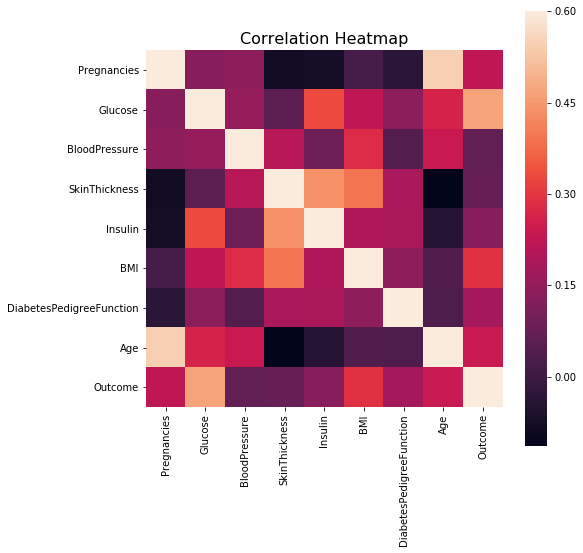

In [7]:
#Take first a look to see which of the different data points correlate 
#with Outcome especially. This investigation formed the basis for 
#choosing the 3 variables, in addition to Outcome, to investigate

correlation = file.corr()
f , ax = plt.subplots(figsize = (8,8))
plt.title('Correlation Heatmap',y=1,size=16)
sns.heatmap(correlation, square = True,  vmax=0.6)

We note that we have not yet handled the invalid 0 values in the dataset, which will, depending on how we handle it affect the correlation matrix. A new correlation matrix will be presented further down, only including the variables chosen for further invetsigation. There we will see that the colors indicating their correlation has changed a bit, as expected. Still, it was considered interesting to take a look a the correlations early in the EDA process, for instance before choosing which variables to focus on.

In [8]:
#Choose to analyse the effect of Number of Pregnancies, Glucose and 
#BMI on whether a person got/has diabetes or not.

#Extract the columns we want to investigate
names = ['Pregnancies', 'Glucose','BMI','Outcome']
df = pd.DataFrame(file, columns=names)

Before we move on in the EDA we want to handle the invalid zeros in our chosen data. We do this only for Glucose and BMI, as it makes sense that there are zeros in the columns which describe the number of pregnancies and Outcome, but not the rest.

In [9]:
# We replace zero values with NaN for Glucose and BMI
df[['Glucose','BMI']] = df[['Glucose','BMI']].replace(0, np.NaN)
print(df.isnull().sum())

Pregnancies     0
Glucose         5
BMI            11
Outcome         0
dtype: int64


There are different ways to handle missing values. We could have dropped the rows for the missing values, as we see that there are not too many of them relative to the size of our dataset. However, in this coursework the NaN values will instead be imputed by filling in the column means. This will affect some statistics calculated further down, but as the number of NaN is relatively small it is not considered problematic for the purpose of this courswork.

In [10]:
# fill missing values with mean value for each column
df.fillna(df.mean(), inplace=True)
print(df.isnull().sum())
print(df.head())

Pregnancies    0
Glucose        0
BMI            0
Outcome        0
dtype: int64
   Pregnancies  Glucose   BMI  Outcome
0            6    148.0  33.6        1
1            1     85.0  26.6        0
2            8    183.0  23.3        1
3            1     89.0  28.1        0
4            0    137.0  43.1        1


We see that now we still have zeros in the columns for Pregnancies and Outcome, but not in those for Glucose and BMI.

In [11]:
#We investigate the data further through a statistical description and
#by checking the datatypes we are working with 
print(round(df.describe(),2))
print(df.info())

       Pregnancies  Glucose     BMI  Outcome
count       768.00   768.00  768.00   768.00
mean          3.85   121.69   32.46     0.35
std           3.37    30.44    6.88     0.48
min           0.00    44.00   18.20     0.00
25%           1.00    99.75   27.50     0.00
50%           3.00   117.00   32.40     0.00
75%           6.00   140.25   36.60     1.00
max          17.00   199.00   67.10     1.00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 4 columns):
Pregnancies    768 non-null int64
Glucose        768 non-null float64
BMI            768 non-null float64
Outcome        768 non-null int64
dtypes: float64(2), int64(2)
memory usage: 24.1 KB
None


If we compared the statistics below with the statistics on the original file-bject - we would see slight differences in certain due how we handled the missing/invalid values. 

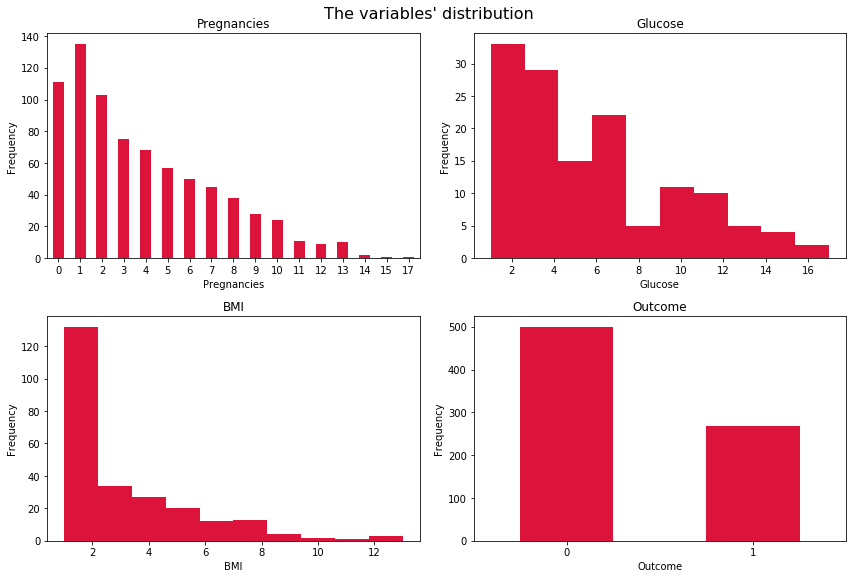

In [12]:
#plot each variable's distribution alone to get a better understanding
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

df[names[0]].value_counts().sort_index().plot.bar(
        ax=ax[0][0], rot=0, color = 'crimson', title=names[0])
ax[0][0].set_xlabel(names[0])
ax[0][0].set_ylabel('Frequency')

df[names[1]].value_counts().sort_index().plot.hist(
    ax=ax[0][1], rot=0, color = 'crimson', title=names[1])
ax[0][1].set_xlabel(names[1])
ax[0][1].set_ylabel('Frequency')
    
df[names[2]].value_counts().sort_index().plot.hist(
        ax=ax[1][0], rot=0, color = 'crimson', title=names[2])
ax[1][0].set_xlabel(names[2])
ax[1][0].set_ylabel('Frequency')

df[names[3]].value_counts().sort_index().plot.bar(
    ax=ax[1][1], rot=0, color = 'crimson', title=names[3])
ax[1][1].set_xlabel(names[3])
ax[1][1].set_ylabel('Frequency')
    
fig.suptitle("The variables' distribution", y = 1, size=16)
plt.tight_layout()
plt.show()

Above we see two bar charts for the variables who can only take on integer values, and histograms for those who are continous. We observe that none of them are normally distributed and that Pregnancies, Glucose and BMI are skewed and have slightly long tails. We can therefore check their skew and kurtosis to verify this.

In [13]:
print("Skew " + "\n" + str(round(df.skew(),2)))

Skew 
Pregnancies    0.90
Glucose        0.53
BMI            0.60
Outcome        0.64
dtype: float64


The positive values for estimated skew supports our observation that the data is right skewed. Outcome also gets an estimated positive skew, as we have fewer 1's than 0's. We note that the Pandas library function for calculating Skew are for the unbiased alternative. However, as our data set holds many observations, this is considered ok.

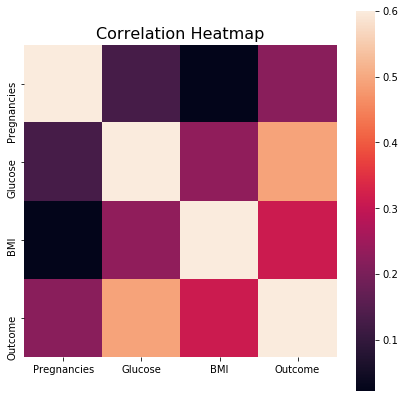

In [14]:
#Take a look at the correlations again, now after the NaN has been handled. 
#If we would compare the colors and calculated correlation with the unhandled data these would be slightly different

correlation = df.corr()
f , ax = plt.subplots(figsize = (7,7))
plt.title('Correlation Heatmap',y=1,size=16)
sns.heatmap(correlation, square = True,  vmax=0.6)

By looking at the correlation between Outcome and three other variables we see by the colors that there is a positive correlation. This is supported by the calculations below, where we have sorted the results as well.

In [15]:
# We can also calculate the correlation
correlation = df.corr()
print(round(correlation,3))

             Pregnancies  Glucose    BMI  Outcome
Pregnancies        1.000    0.128  0.022    0.222
Glucose            0.128    1.000  0.231    0.493
BMI                0.022    0.231  1.000    0.312
Outcome            0.222    0.493  0.312    1.000


In [17]:
# We can also calculate the covariance
covariance = df.cov()
print(round(covariance,3))

             Pregnancies  Glucose     BMI  Outcome
Pregnancies       11.354   13.118   0.500    0.357
Glucose           13.118  926.347  48.325    7.156
BMI                0.500   48.325  47.268    1.023
Outcome            0.357    7.156   1.023    0.227


Based on the calculated correlation and covariance above we observe that all our chosen variables have some degree of correlation and covariance. This will affect the model results as we see will at the end of the coursework.

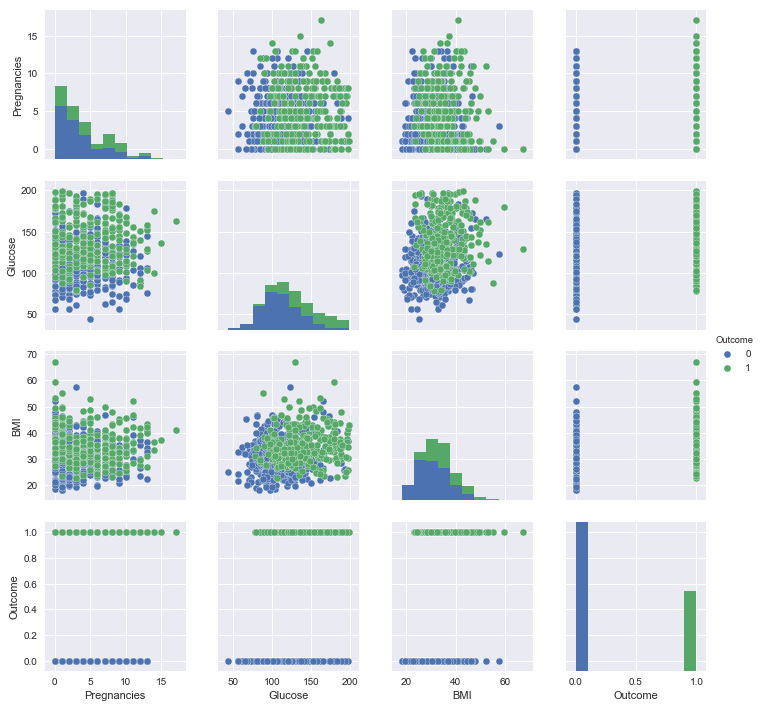

In [27]:
#Furthermore we plot the different values against each 
#other using scatter plots and kde plot. By setting 
#hue="outcome" we can also see the the difference beetween the Outomes.

sns.set()
sns.pairplot(df[names], hue="Outcome")
plt.show()

There are several interesting observations to be made. For instance we can see that for all the 3 variables Pregancies, BMI and Glucose - when plotted against Outcome; the 1's (green colored dots) are slightly shifted upward compared to the 0's. I.e. that with a higher number of pregancies, higher test levels of Glucose and higher BMI score one is more likely to have/get diabetes II. This will be investigated further in the boxplots below. <br>
We can also note other relationships, for instance that it looks as if a higher BMI score is correlated with a higher Glucose level. We see this by noting that the green donts are more shifterd to the upper right corner - compared to the blue dots - when BMI and Glucose is plotted against each other. <br>
We note that it is not really appropriate to use histograms for Pregnancies and Outcome, as these are discrete variables. However, the distplot function will only let us choose between KDE and Histogram on the diagonal, and not bar chart which would be the right choice.<br>

Text(0.5,0.98,'Boxplots grouped by Outcome')

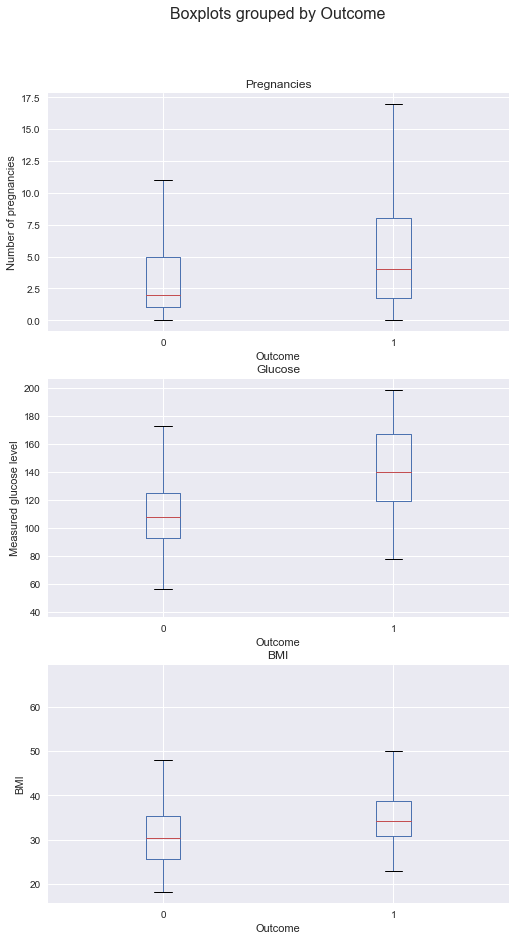

In [17]:
#As we are especially intedersted in predicting Outcome we can
#use box plots against the other variables for further investigation

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,15))

df.boxplot(column='Pregnancies', by='Outcome', ax=axes[0])
df.boxplot(column='Glucose', by='Outcome', ax=axes[1])
df.boxplot(column='BMI', by='Outcome',ax=axes[2])

#set titles
axes[0].set_title('Pregnancies')
axes[1].set_title('Glucose')
axes[2].set_title('BMI')

#label y-axis
axes[0].set_ylabel('Number of pregnancies')
axes[1].set_ylabel('Measured glucose level')
axes[2].set_ylabel('BMI')

fig.suptitle('Boxplots grouped by Outcome', fontsize=16)

As suggested by the visual inspection of the distplot output above, the boxplots support that for all the variables Pregancies, BMI and Glucose - a higher value of these seems to indicate a higher chance of having diabetes II. We see this by the fact the means (red line inside boxes) to the right are alwas above those to the left. The difference seems to be the biggest for Glucose. 

# Model of the relationship between outcome and the other variables using logistic regression

Linear regression is based on the assumption that the outcome is continuous. In our case "Outcome" takes either the value of 0 or 1, and is thus clearly not continuous - but binary. In the case of a binary outcome logistic regression is the method which is appropriate. Here, we will try to fit a line using all the variables Pregnancies, BMI and Glucose.

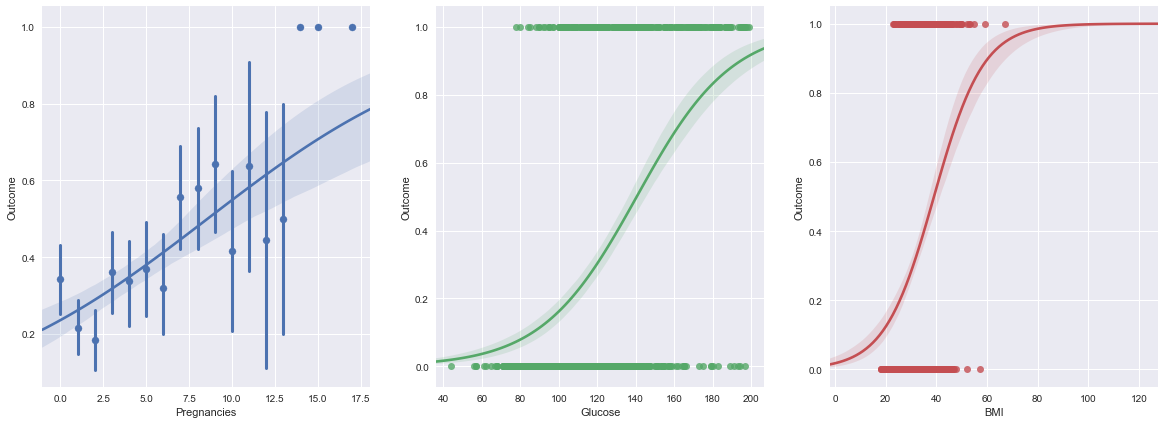

In [28]:
#We can first use the seaborn function regplot to visually inspect the 
#relationship between Outcome and the other variables and how a fitted line would look 
#for each of them separately.

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

plot1 = pd.concat([df[names[0]],df[names[3]]],axis = 1)
sns.regplot(x=names[0],y = names[3],data = plot1, 
            scatter= True, logistic=True, ax=ax[0], x_estimator=np.mean)
#As pregnancies takes only discrete values we 
#collapse the observations into bins which show central tendency and confidence intervals

plot1 = pd.concat([df[names[1]],df[names[3]]],axis = 1)
sns.regplot(x=names[1],y = names[3],data = plot1, 
            scatter= True, logistic=True, ax=ax[1])

plot1 = pd.concat([df[names[2]],df[names[3]]],axis = 1)
sns.regplot(x=names[2],y = names[3],data = plot1, 
            scatter= True, logistic=True, ax=ax[2])

We then move on to actually fit the model.

In [50]:
#Choose the columns we want to use to predict Outcome with
train_cols = df.columns[0:3]

#We use the logit function as we are doing logistic regression
logit = sm.Logit(df['Outcome'], df[train_cols])

# We fit the model
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.645838
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Nov 2018   Pseudo R-squ.:                0.001487
Time:                        09:07:40   Log-Likelihood:                -496.00
converged:                       True   LL-Null:                       -496.74
                                        LLR p-value:                    0.4778
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Pregnancies     0.0611      0.022      2.722      0.006       0.017       0.105
Glucose         0.0093    

From the model summary there are several things to note. Firstly, we note that all the p-values are  small (< 0.01 = ** in R). Suggesting that the coefficient estimates are significant. By looking at the  coefficients we see that we have two which are positive and one which is negative. This can for instance be due to the correlation / covariance we observed between the variables we are here using as predictors together - for Outcome. 

# References

(1) Chosen dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database <br>
(2) National Institue of Diabetes and Digestive and Kidney diseases https://www.niddk.nih.gov/ <br>
(3) Royal Statistical Society - Code of Conduct: http://www.rss.org.uk/RSS/Join_the_RSS/Code_of_conduct/RSS/Join_the_RSS/Code_of_conduct.aspx?hkey=3170e215-12c6-4948-b023-e7253a4600a8